In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

In [22]:
# Load final cleaned dataset
df = pd.read_csv("merged_fire_weather_dataset_cleaned.csv")

# Log-transform acreage (for Model A)
df['Log_Acres_Burned'] = np.log1p(df['Total_Acres_Burned'])

In [26]:
#model A
# Feature list
feature_cols = [
    'T_mean', 'T_max', 'T_min', 'DiurnalRange',
    'RH_min', 'Wind_max', 'Precip',
    'RedFlag', 'SantaAna', 'PDSI', 'ONI', 'ENSO_Phase_Code'
]

# Add one-hot encoded station info
df = pd.get_dummies(df, columns=['Station'], drop_first=True)
feature_cols += [col for col in df.columns if col.startswith("Station_")]

X = df[feature_cols].values
y = df[['Total_Fires', 'Log_Acres_Burned']].values


In [28]:
# Normalize X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [30]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

# Loaders
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=32)

# Model class
class SeriousFireModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 2)  # Fires, Log_Acres
        )

    def forward(self, x):
        return self.net(x)

model = SeriousFireModel(X_train.shape[1])

In [32]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Training loop
for epoch in range(100):
    model.train()
    for xb, yb in train_loader:
        pred = model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_pred = model(X_val_tensor)
        val_loss = criterion(val_pred, y_val_tensor)

    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f}")

Epoch 0 | Train Loss: 10.1342 | Val Loss: 5.5057
Epoch 10 | Train Loss: 1.8009 | Val Loss: 5.1928
Epoch 20 | Train Loss: 7.7310 | Val Loss: 5.2735
Epoch 30 | Train Loss: 6.1163 | Val Loss: 5.1645
Epoch 40 | Train Loss: 5.5123 | Val Loss: 5.1205
Epoch 50 | Train Loss: 2.3156 | Val Loss: 5.0376
Epoch 60 | Train Loss: 1.4133 | Val Loss: 4.9342
Epoch 70 | Train Loss: 0.4780 | Val Loss: 4.9284
Epoch 80 | Train Loss: 1.9482 | Val Loss: 5.2991
Epoch 90 | Train Loss: 2.2595 | Val Loss: 5.1004


In [271]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Evaluate
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_val_tensor)

# Convert tensors to NumPy
y_pred = y_pred_tensor.numpy()
y_true = y_val_tensor.numpy()

# Split outputs
y_true_fires = y_true[:, 0]
y_pred_fires = y_pred[:, 0]

y_true_log_acres = y_true[:, 1]
y_pred_log_acres = y_pred[:, 1]

# Optional: transform back to real acres
y_true_acres = np.expm1(y_true_log_acres)
y_pred_acres = np.expm1(y_pred_log_acres)

#Fires
mae_fires = mean_absolute_error(y_true_fires, y_pred_fires)
rmse_fires = np.sqrt(mean_squared_error(y_true_fires, y_pred_fires))
r2_fires = r2_score(y_true_fires, y_pred_fires)

# 🌲 Acres Burned
mae_acres = mean_absolute_error(y_true_acres, y_pred_acres)
rmse_acres = np.sqrt(mean_squared_error(y_true_acres, y_pred_acres))
r2_acres = r2_score(y_true_acres, y_pred_acres)

# Output
print("Fires Prediction:")
print(f"  MAE:  {mae_fires:.2f}")
print(f"  RMSE: {rmse_fires:.2f}")
print(f"  R²:   {r2_fires:.3f}")

print("\nAcres Burned Prediction:")
print(f"  MAE:  {mae_acres:,.2f}")
print(f"  RMSE: {rmse_acres:,.2f}")
print(f"  R²:   {r2_acres:.3f}")

Fires Prediction:
  MAE:  0.29
  RMSE: 0.51
  R²:   0.051

Acres Burned Prediction:
  MAE:  5,837.67
  RMSE: 30,404.83
  R²:   -0.038


In [42]:
import pandas as pd

# Load clean copy
df_model = pd.read_csv("merged_fire_weather_dataset_cleaned.csv")

# Confirm Station column is there
print(df_model.columns)

Index(['Year', 'Season', 'T_mean', 'T_max', 'T_min', 'RH_min', 'Wind_max',
       'Precip', 'RedFlag', 'SantaAna', 'DiurnalRange', 'Station',
       'Total_Fires', 'Total_Acres_Burned', 'Max_Acres_Burned', 'PDSI', 'ONI',
       'ENSO_Phase', 'ENSO_Phase_Code'],
      dtype='object')


In [44]:
# Log-transform acreage
df_model['Log_Acres_Burned'] = np.log1p(df_model['Total_Acres_Burned'])

# Feature interactions
df_model['WindRH_Interaction'] = df_model['Wind_max'] * (100 - df_model['RH_min'])
df_model['Fire_Weather_Index'] = df_model['RedFlag'] + df_model['SantaAna']
df_model['HotDry_Index'] = df_model['T_max'] * (100 - df_model['RH_min'])

In [46]:
df_model = pd.get_dummies(df_model, columns=['Station'], drop_first=True)

In [48]:
# Define feature list
feature_cols = [
    'T_mean', 'T_max', 'T_min', 'DiurnalRange',
    'RH_min', 'Wind_max', 'Precip',
    'RedFlag', 'SantaAna', 'PDSI', 'ONI', 'ENSO_Phase_Code',
    'WindRH_Interaction', 'Fire_Weather_Index', 'HotDry_Index'
]

# Add one-hot station columns
feature_cols += [col for col in df_model.columns if col.startswith("Station_")]

# Extract X and y
X = df_model[feature_cols].values
y = df_model[['Total_Fires', 'Log_Acres_Burned']].values

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [52]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

# Data loaders
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=32)

# Refined model
class SeriousFireModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 2)  # Output: [Total_Fires, Log_Acres_Burned]
        )

    def forward(self, x):
        return self.net(x)

# Instantiate model
model = SeriousFireModel(X_train.shape[1])

In [58]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)

# Training loop
for epoch in range(100):
    model.train()
    for xb, yb in train_loader:
        pred = model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation loss
    model.eval()
    with torch.no_grad():
        val_pred = model(X_val_tensor)
        val_loss = criterion(val_pred, y_val_tensor)

    scheduler.step(val_loss)

    if epoch % 10 == 0:
        print(f"Epoch {epoch:3d} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f}")

Epoch   0 | Train Loss: 15.2997 | Val Loss: 5.5180
Epoch  10 | Train Loss: 3.5870 | Val Loss: 5.1924
Epoch  20 | Train Loss: 5.2185 | Val Loss: 5.3008
Epoch  30 | Train Loss: 7.2901 | Val Loss: 5.2584
Epoch  40 | Train Loss: 1.7786 | Val Loss: 5.2116
Epoch  50 | Train Loss: 4.3981 | Val Loss: 5.2016
Epoch  60 | Train Loss: 2.0704 | Val Loss: 5.1583
Epoch  70 | Train Loss: 5.3581 | Val Loss: 5.2282
Epoch  80 | Train Loss: 6.0257 | Val Loss: 5.2206
Epoch  90 | Train Loss: 3.4599 | Val Loss: 5.2373


In [60]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Make predictions
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_val_tensor)

# Convert tensors to NumPy
y_pred = y_pred_tensor.numpy()
y_true = y_val_tensor.numpy()

# Split outputs
y_true_fires = y_true[:, 0]
y_pred_fires = y_pred[:, 0]

y_true_log_acres = y_true[:, 1]
y_pred_log_acres = y_pred[:, 1]

# Inverse log-transform to get actual acres burned
y_true_acres = np.expm1(y_true_log_acres)
y_pred_acres = np.expm1(y_pred_log_acres)

# Fire Prediction Metrics
mae_fires = mean_absolute_error(y_true_fires, y_pred_fires)
rmse_fires = np.sqrt(mean_squared_error(y_true_fires, y_pred_fires))
r2_fires = r2_score(y_true_fires, y_pred_fires)

# Acres Burned Metrics
mae_acres = mean_absolute_error(y_true_acres, y_pred_acres)
rmse_acres = np.sqrt(mean_squared_error(y_true_acres, y_pred_acres))
r2_acres = r2_score(y_true_acres, y_pred_acres)

# Display Results
print("Fire Count Prediction:")
print(f"  MAE:  {mae_fires:.2f}")
print(f"  RMSE: {rmse_fires:.2f}")
print(f"  R²:   {r2_fires:.3f}")

print("\nAcres Burned Prediction:")
print(f"  MAE:  {mae_acres:,.2f}")
print(f"  RMSE: {rmse_acres:,.2f}")
print(f"  R²:   {r2_acres:.3f}")

Fire Count Prediction:
  MAE:  0.29
  RMSE: 0.51
  R²:   0.051

Acres Burned Prediction:
  MAE:  5,837.67
  RMSE: 30,404.83
  R²:   -0.038


In [64]:
#Model B
import pandas as pd
import numpy as np

# Reload original dataset
df_b = pd.read_csv("merged_fire_weather_dataset_cleaned.csv")

In [66]:
# Binary target
df_b['High_Risk'] = ((df_b['Total_Fires'] > 3) | 
                     (df_b['Total_Acres_Burned'] > 20000)).astype(int)

# Feature engineering
df_b['Log_Acres_Burned'] = np.log1p(df_b['Total_Acres_Burned'])
df_b['WindRH_Interaction'] = df_b['Wind_max'] * (100 - df_b['RH_min'])
df_b['Fire_Weather_Index'] = df_b['RedFlag'] + df_b['SantaAna']
df_b['HotDry_Index'] = df_b['T_max'] * (100 - df_b['RH_min'])

In [68]:
df_b = pd.get_dummies(df_b, columns=['Station'], drop_first=True)

In [70]:
feature_cols_b = [
    'T_mean', 'T_max', 'T_min', 'DiurnalRange',
    'RH_min', 'Wind_max', 'Precip',
    'RedFlag', 'SantaAna', 'PDSI', 'ONI', 'ENSO_Phase_Code',
    'WindRH_Interaction', 'Fire_Weather_Index', 'HotDry_Index'
]

# Add station columns
feature_cols_b += [col for col in df_b.columns if col.startswith("Station_")]

X_b = df_b[feature_cols_b].values
y_b = df_b['High_Risk'].values

In [72]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler_b = StandardScaler()
X_b_scaled = scaler_b.fit_transform(X_b)

X_train_b, X_val_b, y_train_b, y_val_b = train_test_split(
    X_b_scaled, y_b, test_size=0.2, random_state=42
)

In [74]:
# Convert to tensors
X_train_tensor_b = torch.tensor(X_train_b, dtype=torch.float32)
y_train_tensor_b = torch.tensor(y_train_b, dtype=torch.float32).unsqueeze(1)
X_val_tensor_b = torch.tensor(X_val_b, dtype=torch.float32)
y_val_tensor_b = torch.tensor(y_val_b, dtype=torch.float32).unsqueeze(1)

# Dataloaders
train_loader_b = DataLoader(TensorDataset(X_train_tensor_b, y_train_tensor_b), batch_size=32, shuffle=True)
val_loader_b = DataLoader(TensorDataset(X_val_tensor_b, y_val_tensor_b), batch_size=32)

In [76]:
class FireRiskClassifier(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()  # For binary classification
        )

    def forward(self, x):
        return self.net(x)

model_b = FireRiskClassifier(X_train_b.shape[1])

In [78]:
optimizer = torch.optim.Adam(model_b.parameters(), lr=0.001)
criterion = nn.BCELoss()

# Train loop
for epoch in range(50):
    model_b.train()
    for xb, yb in train_loader_b:
        pred = model_b(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validate
    model_b.eval()
    with torch.no_grad():
        val_pred = model_b(X_val_tensor_b)
        val_loss = criterion(val_pred, y_val_tensor_b)

    if epoch % 10 == 0:
        print(f"Epoch {epoch:3d} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f}")

Epoch   0 | Train Loss: 0.1334 | Val Loss: 0.2878
Epoch  10 | Train Loss: 0.2758 | Val Loss: 0.2571
Epoch  20 | Train Loss: 0.0825 | Val Loss: 0.2568
Epoch  30 | Train Loss: 0.0498 | Val Loss: 0.2730
Epoch  40 | Train Loss: 0.0521 | Val Loss: 0.2633


In [80]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Predict on validation set
model_b.eval()
with torch.no_grad():
    y_prob_b = model_b(X_val_tensor_b).numpy()
    y_pred_b = (y_prob_b > 0.5).astype(int)
    y_true_b = y_val_tensor_b.numpy()

# Metrics
acc = accuracy_score(y_true_b, y_pred_b)
prec = precision_score(y_true_b, y_pred_b)
rec = recall_score(y_true_b, y_pred_b)
f1 = f1_score(y_true_b, y_pred_b)
auc = roc_auc_score(y_true_b, y_prob_b)

# Print
print("Model B: High-Risk Wildfire Classifier")
print(f"  Accuracy : {acc:.3f}")
print(f"  Precision: {prec:.3f}")
print(f"  Recall   : {rec:.3f}")
print(f"  F1 Score : {f1:.3f}")
print(f"  ROC AUC  : {auc:.3f}")

Model B: High-Risk Wildfire Classifier
  Accuracy : 0.900
  Precision: 0.000
  Recall   : 0.000
  F1 Score : 0.000
  ROC AUC  : 0.772


In [94]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Lower threshold
y_pred_b_adj = (y_prob_b > 0.15).astype(int)

# Metrics
acc = accuracy_score(y_true_b, y_pred_b_adj)
prec = precision_score(y_true_b, y_pred_b_adj)
rec = recall_score(y_true_b, y_pred_b_adj)
f1 = f1_score(y_true_b, y_pred_b_adj)

print("Threshold = 0.15")
print(f"  Accuracy : {acc:.3f}")
print(f"  Precision: {prec:.3f}")
print(f"  Recall   : {rec:.3f}")
print(f"  F1 Score : {f1:.3f}")

Threshold = 0.15
  Accuracy : 0.836
  Precision: 0.200
  Recall   : 0.364
  F1 Score : 0.258


In [96]:
# Count positive (high-risk) and negative (low-risk) cases
num_pos = np.sum(y_train_b)
num_neg = len(y_train_b) - num_pos

# Compute positive weight
pos_weight = torch.tensor([num_neg / num_pos], dtype=torch.float32)
print(f"Using pos_weight = {pos_weight.item():.2f}")

Using pos_weight = 13.74


In [98]:
class FireRiskClassifierWeighted(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)  # No sigmoid
        )

    def forward(self, x):
        return self.net(x)

In [100]:
model_b_weighted = FireRiskClassifierWeighted(X_train_b.shape[1])
optimizer = torch.optim.Adam(model_b_weighted.parameters(), lr=0.001)

# Weighted loss
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Training loop
for epoch in range(50):
    model_b_weighted.train()
    for xb, yb in train_loader_b:
        pred = model_b_weighted(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation
    model_b_weighted.eval()
    with torch.no_grad():
        val_pred = model_b_weighted(X_val_tensor_b)
        val_loss = criterion(val_pred, y_val_tensor_b)

    if epoch % 10 == 0:
        print(f"Epoch {epoch:3d} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f}")

Epoch   0 | Train Loss: 1.9868 | Val Loss: 1.4087
Epoch  10 | Train Loss: 0.4433 | Val Loss: 1.2038
Epoch  20 | Train Loss: 1.2846 | Val Loss: 1.1441
Epoch  30 | Train Loss: 0.7243 | Val Loss: 1.2547
Epoch  40 | Train Loss: 0.1838 | Val Loss: 1.3399


In [104]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Get raw logits
model_b_weighted.eval()
with torch.no_grad():
    logits_b = model_b_weighted(X_val_tensor_b)

# Convert logits to probabilities
y_prob_b_weighted = torch.sigmoid(logits_b).numpy()

# Try threshold = 0.15
threshold = 0.15
y_pred_b_weighted = (y_prob_b_weighted > threshold).astype(int)
y_true_b = y_val_tensor_b.numpy()

# Evaluate
acc = accuracy_score(y_true_b, y_pred_b_weighted)
prec = precision_score(y_true_b, y_pred_b_weighted)
rec = recall_score(y_true_b, y_pred_b_weighted)
f1 = f1_score(y_true_b, y_pred_b_weighted)
auc = roc_auc_score(y_true_b, y_prob_b_weighted)

# Display
print("Model B (Weighted Loss) — Threshold =", threshold)
print(f"  Accuracy : {acc:.3f}")
print(f"  Precision: {prec:.3f}")
print(f"  Recall   : {rec:.3f}")
print(f"  F1 Score : {f1:.3f}")
print(f"  ROC AUC  : {auc:.3f}")

Model B (Weighted Loss) — Threshold = 0.15
  Accuracy : 0.664
  Precision: 0.167
  Recall   : 0.818
  F1 Score : 0.277
  ROC AUC  : 0.813


In [112]:
import pandas as pd
import numpy as np
import torch

def simulate_future_risk(
    model, scaler, feature_cols, year, season, station, 
    T_mean, T_max, T_min, RH_min, Wind_max, Precip,
    RedFlag, SantaAna, PDSI, ONI, ENSO_phase_code, threshold=0.15
):
    """
    Simulates wildfire high-risk probability for one seasonal record.
    """
    # Compute engineered features
    DiurnalRange = T_max - T_min
    WindRH_Interaction = Wind_max * (100 - RH_min)
    Fire_Weather_Index = RedFlag + SantaAna
    HotDry_Index = T_max * (100 - RH_min)
    
    # Base record
    data = {
        'Year': year,
        'Season': season,
        'T_mean': T_mean,
        'T_max': T_max,
        'T_min': T_min,
        'DiurnalRange': DiurnalRange,
        'RH_min': RH_min,
        'Wind_max': Wind_max,
        'Precip': Precip,
        'RedFlag': RedFlag,
        'SantaAna': SantaAna,
        'PDSI': PDSI,
        'ONI': ONI,
        'ENSO_Phase_Code': ENSO_phase_code,
        'WindRH_Interaction': WindRH_Interaction,
        'Fire_Weather_Index': Fire_Weather_Index,
        'HotDry_Index': HotDry_Index
    }

    # Add dummy station columns
    dummy_stations = [col for col in feature_cols if col.startswith("Station_")]
    for st in dummy_stations:
        data[st] = 1 if st == f'Station_{station}' else 0

    # Ensure all expected features exist
    for col in feature_cols:
        if col not in data:
            data[col] = 0

    # Convert to DataFrame and order columns
    df_future = pd.DataFrame([data])[feature_cols]

    # Scale
    X_scaled = scaler.transform(df_future.values)
    X_tensor = torch.tensor(X_scaled, dtype=torch.float32)

    # Predict
    model.eval()
    with torch.no_grad():
        logits = model(X_tensor)
        prob = torch.sigmoid(logits).item()
        label = int(prob > threshold)

    return {
        'Year': year,
        'Season': season,
        'Station': station,
        'Risk_Probability': round(prob, 3),
        'Predicted_High_Risk': label
    }

In [188]:
stations = ["KOXR", "KCMA", "CEEC1", "DVLC1", "LCBC1", "KNTD", "OZNC1"]

# Define simulation parameters by decade
scenarios = [
    {"year": 2030, "T_mean": 72, "T_max": 87, "T_min": 58, "RH_min": 10, "Wind_max": 45,
     "Precip": 0.2, "RedFlag": 6, "SantaAna": 7, "PDSI": -2.0, "ONI": 0.6, "ENSO_phase_code": 0},
    
    {"year": 2040, "T_mean": 74, "T_max": 90, "T_min": 60, "RH_min": 6, "Wind_max": 35,
     "Precip": 0.1, "RedFlag": 8, "SantaAna": 10, "PDSI": -2.8, "ONI": -0.4, "ENSO_phase_code": -1},
    
    {"year": 2050, "T_mean": 76, "T_max": 94, "T_min": 62, "RH_min": 5, "Wind_max": 50,
     "Precip": 0.0, "RedFlag": 10, "SantaAna": 12, "PDSI": -3.3, "ONI": 1.1, "ENSO_phase_code": 1}
]


In [190]:
results = []

for scenario in scenarios:
    for station in stations:
        result = simulate_future_risk(
            model=model_b_weighted,
            scaler=scaler_b,
            feature_cols=feature_cols_b,
            year=scenario['year'],
            season="Fall",
            station=station,
            T_mean=scenario['T_mean'],
            T_max=scenario['T_max'],
            T_min=scenario['T_min'],
            RH_min=scenario['RH_min'],
            Wind_max=scenario['Wind_max'],
            Precip=scenario['Precip'],
            RedFlag=scenario['RedFlag'],
            SantaAna=scenario['SantaAna'],
            PDSI=scenario['PDSI'],
            ONI=scenario['ONI'],
            ENSO_phase_code=scenario['ENSO_phase_code'],
            threshold=0.15
        )
        results.append(result)

# Create DataFrame
future_risk_df = pd.DataFrame(results)
future_risk_df.sort_values(['Year', 'Station'], inplace=True)

In [192]:
print(future_risk_df[['Year', 'Season', 'Station', 'Risk_Probability', 'Predicted_High_Risk']])

    Year Season Station  Risk_Probability  Predicted_High_Risk
2   2030   Fall   CEEC1             0.105                    0
3   2030   Fall   DVLC1             0.064                    0
1   2030   Fall    KCMA             0.207                    1
5   2030   Fall    KNTD             0.063                    0
0   2030   Fall    KOXR             0.087                    0
4   2030   Fall   LCBC1             0.033                    0
6   2030   Fall   OZNC1             0.032                    0
9   2040   Fall   CEEC1             0.966                    1
10  2040   Fall   DVLC1             0.851                    1
8   2040   Fall    KCMA             0.976                    1
12  2040   Fall    KNTD             0.976                    1
7   2040   Fall    KOXR             0.970                    1
11  2040   Fall   LCBC1             0.767                    1
13  2040   Fall   OZNC1             0.941                    1
16  2050   Fall   CEEC1             0.552              

In [194]:
df_c = df_b.copy()  # Clean slate

# Drop target columns — we’re not doing supervised learning here
df_c = df_c.drop(columns=[
    'Total_Fires', 'Total_Acres_Burned', 'High_Risk'
], errors='ignore')  # in case they're still in the copy

In [196]:
X_c = df_c[feature_cols_b].values

In [198]:
from sklearn.preprocessing import StandardScaler

scaler_c = StandardScaler()
X_c_scaled = scaler_c.fit_transform(X_c)

In [200]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

class AE(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

model_c = AE(input_dim=X_c.shape[1])

In [202]:
X_tensor_c = torch.tensor(X_c_scaled, dtype=torch.float32)
loader_c = DataLoader(TensorDataset(X_tensor_c), batch_size=32, shuffle=True)

optimizer = torch.optim.Adam(model_c.parameters(), lr=0.001)
criterion = nn.MSELoss()

for epoch in range(100):
    model_c.train()
    epoch_loss = 0
    for xb, in loader_c:
        recon = model_c(xb)
        loss = criterion(recon, xb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Loss: {epoch_loss:.4f}")

Epoch 0 | Loss: 20.9336
Epoch 10 | Loss: 1.2879
Epoch 20 | Loss: 0.5082
Epoch 30 | Loss: 0.3188
Epoch 40 | Loss: 0.2019
Epoch 50 | Loss: 0.1351
Epoch 60 | Loss: 0.1044
Epoch 70 | Loss: 0.0909
Epoch 80 | Loss: 0.0771
Epoch 90 | Loss: 0.0669


In [216]:
#MODEL C
df_c = pd.read_csv("merged_fire_weather_dataset_cleaned.csv")

In [218]:
df_c = df_c.drop(columns=[
    'Total_Fires', 'Total_Acres_Burned', 'Max_Acres_Burned', 'High_Risk'
], errors='ignore')

In [220]:
df_c = pd.get_dummies(df_c, columns=['Station'], drop_first=False)

In [222]:
feature_cols_c = [
    'T_mean', 'T_max', 'T_min', 'DiurnalRange',
    'RH_min', 'Wind_max', 'Precip',
    'RedFlag', 'SantaAna', 'PDSI', 'ONI', 'ENSO_Phase_Code',
    'WindRH_Interaction', 'Fire_Weather_Index', 'HotDry_Index'
] + [col for col in df_c.columns if col.startswith("Station_")]

In [226]:
# Diurnal Range is already present — skip if it's there

df_c['WindRH_Interaction'] = df_c['Wind_max'] * (100 - df_c['RH_min'])
df_c['Fire_Weather_Index'] = df_c['RedFlag'] + df_c['SantaAna']
df_c['HotDry_Index'] = df_c['T_max'] * (100 - df_c['RH_min'])

In [228]:
X_c = df_c[feature_cols_c].values

In [230]:
from sklearn.preprocessing import StandardScaler
import torch

scaler_c = StandardScaler()
X_c_scaled = scaler_c.fit_transform(X_c)

X_tensor_c = torch.tensor(X_c_scaled, dtype=torch.float32)

In [232]:
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

class AE(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

model_c = AE(input_dim=X_c.shape[1])

In [234]:
loader_c = DataLoader(TensorDataset(X_tensor_c), batch_size=32, shuffle=True)
optimizer = torch.optim.Adam(model_c.parameters(), lr=0.001)
criterion = nn.MSELoss()

for epoch in range(100):
    model_c.train()
    for xb, in loader_c:
        pred = model_c(xb)
        loss = criterion(pred, xb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.6f}")

Epoch 0 | Loss: 0.717736
Epoch 10 | Loss: 0.040485
Epoch 20 | Loss: 0.022979
Epoch 30 | Loss: 0.010637
Epoch 40 | Loss: 0.007419
Epoch 50 | Loss: 0.004863
Epoch 60 | Loss: 0.004374
Epoch 70 | Loss: 0.005760
Epoch 80 | Loss: 0.003182
Epoch 90 | Loss: 0.003170


In [236]:
model_c.eval()
with torch.no_grad():
    X_reconstructed = model_c(X_tensor_c).numpy()

reconstruction_errors = np.mean((X_c_scaled - X_reconstructed) ** 2, axis=1)
df_c['Reconstruction_Error'] = reconstruction_errors

In [239]:
threshold = np.percentile(reconstruction_errors, 90)
df_c['Anomaly'] = (df_c['Reconstruction_Error'] > threshold).astype(int)

In [249]:
# If you have 'Station' as one-hot columns
station_cols = [col for col in df_c.columns if col.startswith("Station_")]
df_c['Station'] = df_c[station_cols].idxmax(axis=1).str.replace("Station_", "")

# View top 10
print(df_c[['Year', 'Season', 'Station', 'Reconstruction_Error', 'Anomaly']].sort_values('Reconstruction_Error', ascending=False).head(20))

     Year  Season Station  Reconstruction_Error  Anomaly
514  2002  Spring    KNTD              0.022696        1
519  2003  Summer    KNTD              0.021141        1
606  2001    Fall   OZNC1              0.020337        1
648  2012  Spring   OZNC1              0.018431        1
649  2012  Summer   OZNC1              0.018184        1
529  2006    Fall    KNTD              0.009437        1
520  2003  Winter    KNTD              0.008781        1
310  2001  Winter   DVLC1              0.008612        1
609  2002  Summer   OZNC1              0.007975        1
471  2016  Winter   LCBC1              0.007760        1
424  2005    Fall   LCBC1              0.006902        1
565  2015    Fall    KNTD              0.006818        1
559  2013  Summer    KNTD              0.006528        1
679  2020    Fall   OZNC1              0.006217        1
622  2005  Winter   OZNC1              0.006137        1
616  2004  Spring   OZNC1              0.006024        1
241  2009  Winter   CEEC1      

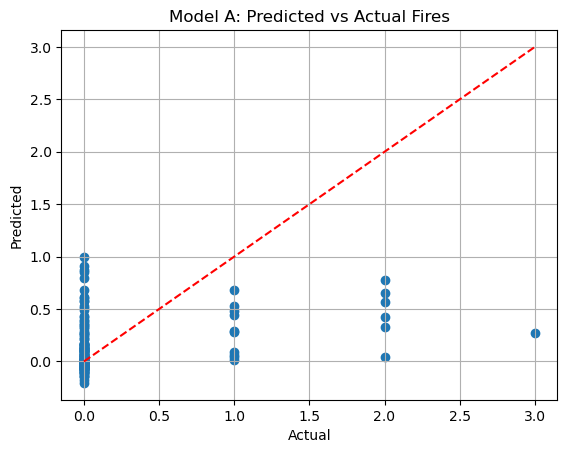

In [251]:
import matplotlib.pyplot as plt
plt.scatter(y_true_fires, y_pred_fires, label='Fires')
plt.plot([min(y_true_fires), max(y_true_fires)], [min(y_true_fires), max(y_true_fires)], 'r--')
plt.title("Model A: Predicted vs Actual Fires")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.grid()

In [261]:
#model b
model_b_weighted.eval()

# Predict probabilities
with torch.no_grad():
    y_probs = torch.sigmoid(model_b_weighted(torch.tensor(X_b_scaled, dtype=torch.float32))).numpy().flatten()

# Your true labels
y_true = y_b  # should already be defined as your binary high-risk labels

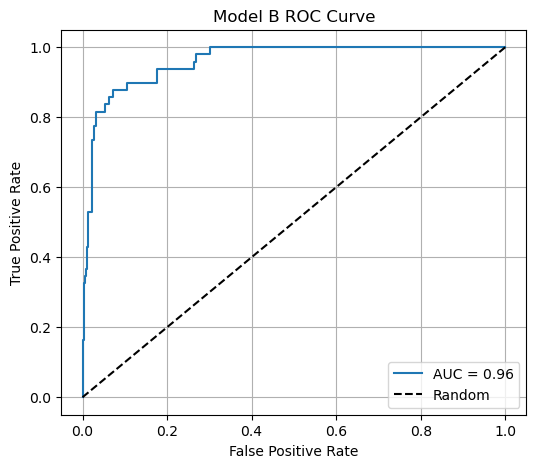

In [263]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Model B ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

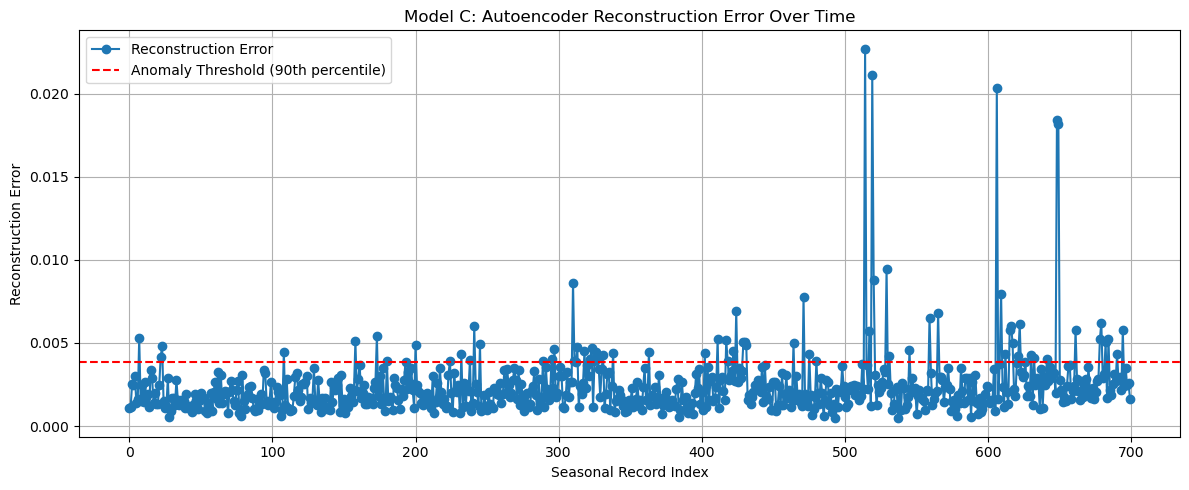

In [265]:
#model C
import matplotlib.pyplot as plt
df_c[df_c['Anomaly'] == 1]['Station'].value_counts().plot(
    kind='barh',
    title="Anomalies by Station (Model C)",
    figsize=(8, 5),
    color='tomato'
)
plt.xlabel("Anomaly Count")
plt.grid(axis='x')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(df_c.index, df_c['Reconstruction_Error'], label='Reconstruction Error', marker='o')
plt.axhline(np.percentile(df_c['Reconstruction_Error'], 90), color='red', linestyle='--', label='Anomaly Threshold (90th percentile)')
plt.title("Model C: Autoencoder Reconstruction Error Over Time")
plt.xlabel("Seasonal Record Index")
plt.ylabel("Reconstruction Error")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

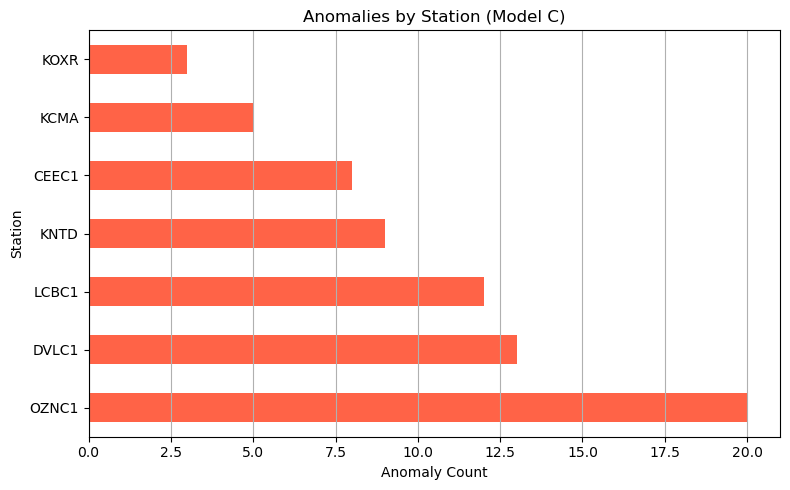

In [267]:
df_c[df_c['Anomaly'] == 1]['Station'].value_counts().plot(
    kind='barh',
    title="Anomalies by Station (Model C)",
    figsize=(8, 5),
    color='tomato'
)
plt.xlabel("Anomaly Count")
plt.grid(axis='x')
plt.tight_layout()
plt.show()